[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/evals/ragas-evaluation.ipynb)

[![View Article](https://img.shields.io/badge/View%20Article-blue)](https://www.mongodb.com/developer/products/atlas/evaluate-llm-applications-rag/?utm_campaign=devrel&utm_source=cross-post&utm_medium=organic_social&utm_content=https%3A%2F%2Fgithub.com%2Fmongodb-developer%2FGenAI-Showcase&utm_term=apoorva.joshi)


# RAG Series Part 2: How to evaluate your RAG application

This notebook shows how to evaluate a RAG application using the [RAGAS](https://docs.ragas.io/en/stable/index.html) framework.


## Step 1: Install required libraries

- **datasets**: Python library to get access to datasets available on Hugging Face Hub
<p>
- **ragas**: Python library for the RAGAS framework
<p>
- **langchain**: Python library to develop LLM applications using LangChain
<p>
- **langchain-mongodb**: Python package to use MongoDB Atlas vector Search with LangChain
<p>
- **langchain-openai**: Python package to use OpenAI models in LangChain
<p>
- **pymongo**: Python driver to interacting with MongoDB
<p>
- **pandas**: Python library for data analysis, exploration and manipulation
<p>
- **tdqm**: Python module to show a progress meter for loops
<p>
- **matplotlib, seaborn**: Python libraries for data visualization


In [13]:
! pip install -qU datasets ragas langchain langchain-mongodb langchain-openai \
pymongo pandas tqdm matplotlib seaborn

## Step 2: Setup pre-requisites


- Set the MongoDB connection string. Follow the steps [here](https://www.mongodb.com/docs/manual/reference/connection-string/) to get the connection string from the Atlas UI.

- Set the OpenAI API key. Steps to obtain an API key as [here](https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key)


In [11]:
import os
import getpass
from openai import OpenAI

In [28]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
openai_client = OpenAI()

Enter your OpenAI API Key:········


In [12]:
MONGODB_URI = getpass.getpass("Enter your MongoDB connection string:")

Enter your MongoDB connection string:········


## Step 3: Download the evaluation dataset


In [30]:
from datasets import load_dataset
import pandas as pd

In [31]:
data = load_dataset("explodinggradients/ragas-wikiqa", split="train")
df = pd.DataFrame(data)

In [32]:
df.head(1)

,question,correct_answer,incorrect_answer,question_id,generated_with_rag,context,generated_without_rag
0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,"As such, African immigrants are to be distingu...",From the Immigration and Nationality Act of 19...,Q0,\nAfrican Americans were immigrated to the Uni...,[African immigration to the United States refe...,African Americans were immigrated to the US in...


In [33]:
len(df)

232

## Step 4: Create reference document chunks


In [21]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import List

In [22]:
# Split text by tokens using the tiktoken tokenizer
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", keep_separator=False, chunk_size=200, chunk_overlap=30
)

In [23]:
def split_texts(texts: List[str]) -> List[str]:
    """
    Split large texts into chunks

    Args:
        texts (List[str]): List of reference texts

    Returns:
        List[str]: List of chunked texts
    """
    chunked_texts = []
    for text in texts:
        chunks = text_splitter.create_documents([text])
        chunked_texts.extend([chunk.page_content for chunk in chunks])
    return chunked_texts

In [24]:
# Split the context field into chunks
df["chunks"] = df["context"].apply(lambda x: split_texts(x))

In [25]:
# Aggregate list of all chunks
all_chunks = df["chunks"].tolist()
docs = [item for chunk in all_chunks for item in chunk]

In [29]:
len(docs)

3795

In [40]:
docs[100]

'Figgis had problems because permits were not issued for some street scenes. This caused him to film some scenes on the Las Vegas strip in one take to avoid the police, which Figgis said benefited production and the authenticity of the acting, remarking "I\'ve always hated the convention of shooting on a street, and then having to stop the traffic, and then having to tell the actors, \'Well, there\'s meant to be traffic here, so you\'re going to have to shout.\' And they\'re shouting, but it\'s quiet and they feel really stupid, because it\'s unnatural. You put them up against a couple of trucks, with it all happening around them, and their voices become great". Filming took place over 28 days.'

## Step 5: Create embeddings and ingest them into MongoDB


In [14]:
from pymongo import MongoClient
from tqdm.auto import tqdm

In [42]:
def get_embeddings(docs: List[str], model: str) -> List[List[float]]:
    """
    Generate embeddings using the OpenAI API.

    Args:
        docs (List[str]): List of texts to embed
        model (str, optional): Model name. Defaults to "text-embedding-3-large".

    Returns:
        List[float]: Array of embeddings
    """
    # replace newlines, which can negatively affect performance.
    docs = [doc.replace("\n", " ") for doc in docs]
    response = openai_client.embeddings.create(input=docs, model=model)
    response = [r.embedding for r in response.data]
    return response

In [ ]:
client = MongoClient(MONGODB_URI, appname="devrel.content.python")
DB_NAME = "ragas_evals"
db = client[DB_NAME]

In [44]:
batch_size = 128

In [45]:
EVAL_EMBEDDING_MODELS = ["text-embedding-ada-002", "text-embedding-3-small"]

In [46]:
for model in EVAL_EMBEDDING_MODELS:
    embedded_docs = []
    print(f"Getting embeddings for the {model} model")
    for i in tqdm(range(0, len(docs), batch_size)):
        end = min(len(docs), i + batch_size)
        batch = docs[i:end]
        # Generate embeddings for current batch
        batch_embeddings = get_embeddings(batch, model)
        # Creating the documents to ingest into MongoDB for current batch
        batch_embedded_docs = [
            {"text": batch[i], "embedding": batch_embeddings[i]}
            for i in range(len(batch))
        ]
        embedded_docs.extend(batch_embedded_docs)
    print(f"Finished getting embeddings for the {model} model")

    # Bulk insert documents into a MongoDB collection
    print(f"Inserting embeddings for the {model} model")
    collection = db[model]
    collection.delete_many({})
    collection.insert_many(embedded_docs)
    print(f"Finished inserting embeddings for the {model} model")

Getting embeddings for the text-embedding-ada-002 model


  0%|          | 0/30 [00:00<?, ?it/s]

Finished getting embeddings for the text-embedding-ada-002 model
Inserting embeddings for the text-embedding-ada-002 model
Finished inserting embeddings for the text-embedding-ada-002 model
Getting embeddings for the text-embedding-3-small model


  0%|          | 0/30 [00:00<?, ?it/s]

Finished getting embeddings for the text-embedding-3-small model
Inserting embeddings for the text-embedding-3-small model
Finished inserting embeddings for the text-embedding-3-small model


## Step 6: Compare embedding models for retrieval


In [47]:
from langchain_openai import OpenAIEmbeddings
from langchain_mongodb import MongoDBAtlasVectorSearch
from langchain_core.vectorstores import VectorStoreRetriever
from datasets import Dataset
from ragas import evaluate, RunConfig
from ragas.metrics import context_precision, context_recall
import nest_asyncio

# Allow nested use of asyncio (used by RAGAS)
nest_asyncio.apply()

In [48]:
def get_retriever(model: str, k: int) -> VectorStoreRetriever:
    """
    Given an embedding model and top k, get a vector store retriever object

    Args:
        model (str): Embedding model to use
        k (int): Number of results to retrieve

    Returns:
        VectorStoreRetriever: A vector store retriever object
    """
    embeddings = OpenAIEmbeddings(model=model)

    vector_store = MongoDBAtlasVectorSearch.from_connection_string(
        connection_string=MONGODB_URI,
        namespace=f"{DB_NAME}.{model}",
        embedding=embeddings,
        index_name="vector_index",
        text_key="text",
    )

    retriever = vector_store.as_retriever(
        search_type="similarity", search_kwargs={"k": k}
    )
    return retriever

In [49]:
QUESTIONS = df["question"].to_list()
GROUND_TRUTH = df["correct_answer"].tolist()

In [50]:
for model in EVAL_EMBEDDING_MODELS:
    data = {"question": [], "ground_truth": [], "contexts": []}
    data["question"] = QUESTIONS
    data["ground_truth"] = GROUND_TRUTH

    retriever = get_retriever(model, 2)
    # Getting relevant documents for the evaluation dataset
    for question in tqdm(QUESTIONS):
        data["contexts"].append(
            [doc.page_content for doc in retriever.get_relevant_documents(question)]
        )
    # RAGAS expects a Dataset object
    dataset = Dataset.from_dict(data)
    # RAGAS runtime settings to avoid hitting OpenAI rate limits
    run_config = RunConfig(max_workers=4, max_wait=180)
    result = evaluate(
        dataset=dataset,
        metrics=[context_precision, context_recall],
        run_config=run_config,
        raise_exceptions=False,
    )
    print(f"Result for the {model} model: {result}")

  0%|          | 0/232 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Result for the text-embedding-ada-002 model: {'context_precision': 0.9310, 'context_recall': 0.8561}


  0%|          | 0/232 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

Result for the text-embedding-3-small model: {'context_precision': 0.9116, 'context_recall': 0.8826}


## Step 7: Compare completion models for generation


In [51]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.base import RunnableSequence
from langchain_core.output_parsers import StrOutputParser
from ragas.metrics import faithfulness, answer_relevancy

In [52]:
def get_rag_chain(retriever: VectorStoreRetriever, model: str) -> RunnableSequence:
    """
    Create a basic RAG chain

    Args:
        retriever (VectorStoreRetriever): Vector store retriever object
        model (str): Chat completion model to use

    Returns:
        RunnableSequence: A RAG chain
    """
    # Generate context using the retriever, and pass the user question through
    retrieve = {
        "context": retriever
        | (lambda docs: "\n\n".join([d.page_content for d in docs])),
        "question": RunnablePassthrough(),
    }
    template = """Answer the question based only on the following context: \
    {context}

    Question: {question}
    """
    # Defining the chat prompt
    prompt = ChatPromptTemplate.from_template(template)
    # Defining the model to be used for chat completion
    llm = ChatOpenAI(temperature=0, model=model)
    # Parse output as a string
    parse_output = StrOutputParser()

    # Naive RAG chain
    rag_chain = retrieve | prompt | llm | parse_output
    return rag_chain

In [54]:
for model in ["gpt-3.5-turbo-1106", "gpt-3.5-turbo"]:
    data = {"question": [], "ground_truth": [], "contexts": [], "answer": []}
    data["question"] = QUESTIONS
    data["ground_truth"] = GROUND_TRUTH
    # Using the best embedding model from the retriever evaluation
    retriever = get_retriever("text-embedding-3-small", 2)
    rag_chain = get_rag_chain(retriever, model)
    for question in tqdm(QUESTIONS):
        data["answer"].append(rag_chain.invoke(question))
        data["contexts"].append(
            [doc.page_content for doc in retriever.get_relevant_documents(question)]
        )
    # RAGAS expects a Dataset object
    dataset = Dataset.from_dict(data)
    # RAGAS runtime settings to avoid hitting OpenAI rate limits
    run_config = RunConfig(max_workers=4, max_wait=180)
    result = evaluate(
        dataset=dataset,
        metrics=[faithfulness, answer_relevancy],
        run_config=run_config,
        raise_exceptions=False,
    )
    print(f"Result for the {model} model: {result}")

  0%|          | 0/232 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.


Result for the gpt-3.5-turbo-1106 model: {'faithfulness': 0.9671, 'answer_relevancy': 0.9105}


  0%|          | 0/232 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.


Result for the gpt-3.5-turbo model: {'faithfulness': 0.9714, 'answer_relevancy': 0.9087}


## Step 8: Measure overall performance of the RAG application


In [55]:
from ragas.metrics import answer_similarity, answer_correctness

In [56]:
data = {"question": [], "ground_truth": [], "answer": []}
data["question"] = QUESTIONS
data["ground_truth"] = GROUND_TRUTH
# Using the best embedding model from the retriever evaluation
retriever = get_retriever("text-embedding-3-small", 2)
# Using the best completion model from the generator evaluation
rag_chain = get_rag_chain(retriever, "gpt-3.5-turbo")
for question in tqdm(QUESTIONS):
    data["answer"].append(rag_chain.invoke(question))

dataset = Dataset.from_dict(data)
run_config = RunConfig(max_workers=4, max_wait=180)
result = evaluate(
    dataset=dataset,
    metrics=[answer_similarity, answer_correctness],
    run_config=run_config,
    raise_exceptions=False,
)
print(f"Overall metrics: {result}")

  0%|          | 0/232 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

Overall metrics: {'answer_similarity': 0.8873, 'answer_correctness': 0.5922}


In [57]:
result_df = result.to_pandas()

In [58]:
result_df.head(5)

,question,ground_truth,answer,answer_similarity,answer_correctness
0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,"As such, African immigrants are to be distingu...",African Americans were involuntarily brought f...,0.913499,0.603375
1,what are points on a mortgage,"Points, sometimes also called a ""discount poin...",Points on a mortgage are a form of pre-paid in...,0.914100,0.528525
2,how does interlibrary loan work,The user makes a request with their local libr...,Interlibrary loan works by allowing patrons of...,0.885328,0.864189
3,WHAT IS A FY QUARTER,"A fiscal year (or financial year, or sometimes...",A FY quarter is a three-month period within a ...,0.872582,0.718120
4,who wrote a rose is a rose is a rose,"The sentence ""Rose is a rose is a rose is a ro...",Gertrude Stein,0.868273,0.592068


In [60]:
result_df[result_df["answer_correctness"] < 0.7]

,question,ground_truth,answer,answer_similarity,answer_correctness
0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,"As such, African immigrants are to be distingu...",African Americans were involuntarily brought f...,0.913499,0.603375
1,what are points on a mortgage,"Points, sometimes also called a ""discount poin...",Points on a mortgage are a form of pre-paid in...,0.914100,0.528525
4,who wrote a rose is a rose is a rose,"The sentence ""Rose is a rose is a rose is a ro...",Gertrude Stein,0.868273,0.592068
6,what bacteria grow on macconkey agar,MacConkey agar is a culture medium designed to...,Gram-negative and enteric bacteria grow on Mac...,0.905663,0.526416
10,what is a day care for?,Child care or day care is the care of a child ...,A day care is for the care and supervision of ...,0.945214,0.536303
...,...,...,...,...,...
224,how many asian indians live in usa,Indian Americans are citizens of the United St...,Approximately 4.5 million Indian Americans liv...,0.888910,0.597227
225,what happened to george o'malley on grey's ana...,"In 2007, Knight's co-star Isaiah Washington ( ...",George O'Malley died on Grey's Anatomy.,0.805490,0.201374
226,how much did yankee stadium cost,Also controversial was the price tag of $1.5 b...,$2.3 billion,0.773524,0.193381
229,how kimberlite pipes form,Volcanic pipes are relatively rare.,Kimberlite pipes form when an eruption ejects ...,0.818068,0.204517


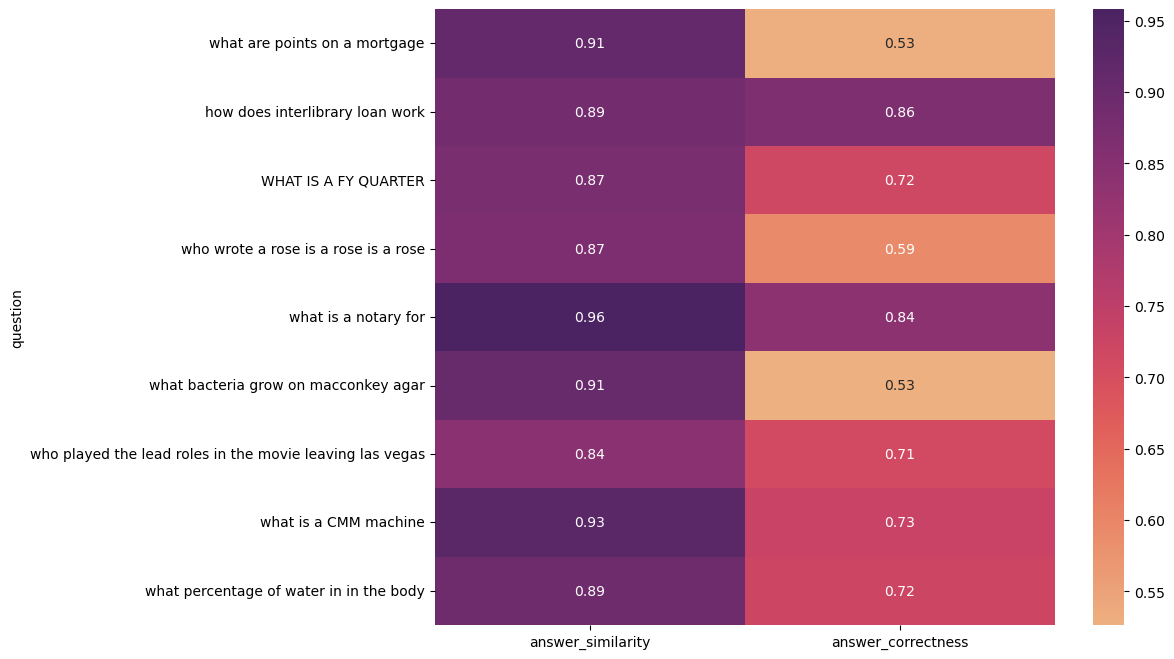

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    result_df[1:10].set_index("question")[["answer_similarity", "answer_correctness"]],
    annot=True,
    cmap="flare",
)
plt.show()

## Step 9: Tracking performance over time


In [2]:
from datetime import datetime

In [6]:
result["timestamp"] = datetime.now()

In [22]:
collection = db["metrics"]
collection.insert_one(result)

InsertOneResult(ObjectId('66132f1305da5dc970ad919c'), acknowledged=True)